## Example for calibration of Sattelite LiDAR to plane LiDAR

In the original article on tree regrowth, there is a simple linear regresion between the plane heights and the sattelite heights, correcting for assumed innate *linear* bias in the sattelite measurements by linearly calibrating to fit the data.

There are couple of problems with it
* Data is very noisy, so linear calibration still yields high variance
* Data is not consistently noisy (biased)

I will show it in a moment


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [2]:
data = pd.read_hdf('data/data.h5')

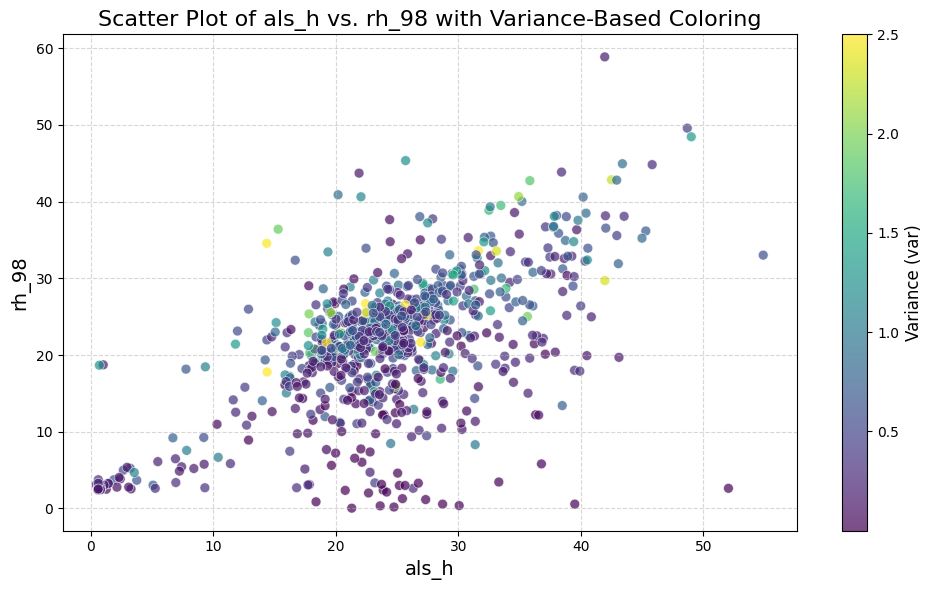

In [3]:
data = pd.read_hdf('data/data.h5')

import matplotlib.pyplot as plt

rh_98 = data['rh_98'].to_numpy()
rh_99 = data['rh_99'].to_numpy()
rh_100 = data['rh_100'].to_numpy()
stacked = np.vstack([rh_98, rh_99, rh_100])
# stacked = stacked / np.mean(stacked, axis=0)
variance_vector = np.var(stacked, axis=0)
data['var'] = np.clip(variance_vector, a_min=0, a_max=2.5)
# data = data[data['var'] < 0.1]

# plt.scatter(data['als_h'], data['rh_98'])
# plt.xlabel('als_h')
# plt.ylabel('rh_98')
# plt.show()

# Define the figure size for better readability
plt.figure(figsize=(10, 6))

# Create the scatter plot
scatter = plt.scatter(
    data['als_h'],        # X-axis data
    data['rh_98'],        # Y-axis data
    c=data['var'],        # Color mapped to 'var'
    cmap='viridis',       # Colormap (choose one that suits your preference)
    s=50,                  # Marker size
    alpha=0.7,             # Transparency for better visibility
    edgecolors='w',        # White edges for markers
    linewidth=0.5
)

# Add a colorbar to map colors to variance values
cbar = plt.colorbar(scatter)
cbar.set_label('Variance (var)', fontsize=12)

# Set plot labels and title
plt.xlabel('als_h', fontsize=14)
plt.ylabel('rh_98', fontsize=14)
plt.title('Scatter Plot of als_h vs. rh_98 with Variance-Based Coloring', fontsize=16)

# Improve layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

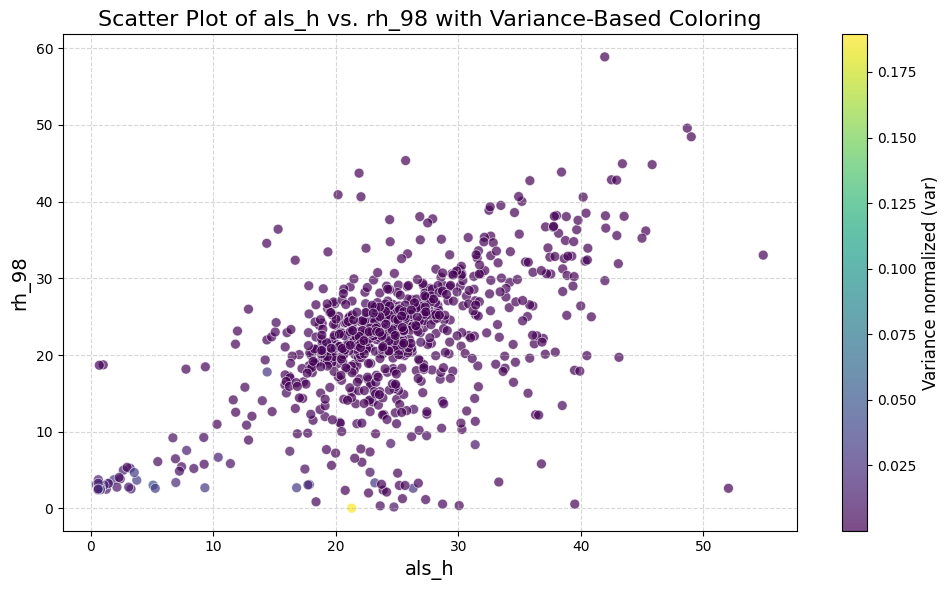

In [4]:
data = pd.read_hdf('data/data.h5')

import matplotlib.pyplot as plt

rh_98 = data['rh_98'].to_numpy()
rh_99 = data['rh_99'].to_numpy()
rh_100 = data['rh_100'].to_numpy()
stacked = np.vstack([rh_98, rh_99, rh_100])
stacked = stacked / np.mean(stacked, axis=0)
variance_vector = np.var(stacked, axis=0)
data['var'] = np.clip(variance_vector, a_min=0, a_max=2.5)
# data = data[data['var'] < 0.1]

# plt.scatter(data['als_h'], data['rh_98'])
# plt.xlabel('als_h')
# plt.ylabel('rh_98')
# plt.show()

# Define the figure size for better readability
plt.figure(figsize=(10, 6))

# Create the scatter plot
scatter = plt.scatter(
    data['als_h'],        # X-axis data
    data['rh_98'],        # Y-axis data
    c=data['var'],        # Color mapped to 'var'
    cmap='viridis',       # Colormap (choose one that suits your preference)
    s=50,                  # Marker size
    alpha=0.7,             # Transparency for better visibility
    edgecolors='w',        # White edges for markers
    linewidth=0.5
)

# Add a colorbar to map colors to variance values
cbar = plt.colorbar(scatter)
cbar.set_label('Variance normalized (var)', fontsize=12)

# Set plot labels and title
plt.xlabel('als_h', fontsize=14)
plt.ylabel('rh_98', fontsize=14)
plt.title('Scatter Plot of als_h vs. rh_98 with Variance-Based Coloring', fontsize=16)

# Improve layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()

Looking at the plot above, we see a confirmation of high variance, and high bias (many rh_98 around 0~10m but als_h is all over the place)

So with these features, improvement is hard. But we can make improvements using the other columns:

In [4]:
data.columns

Index(['degrade_flag', 'quality_flag', 'rx_assess_quality_flag', 'Latitude',
       'Longitude', 'BEAM', 'solar_elevation', 'Site', 'rh_100', 'rh_99',
       'rh_98', 'als_h', 'sensitivity', 'geolocation_sensitivity_a2',
       'selected_algorithm'],
      dtype='object')

Let's go through the feature importance using a simple RandomForestRegressor

In [5]:
import numpy as np
data['diff'] = np.abs(diff['als_h'] - diff['rh_98'])

X = data.drop(columns=['als_h', 'rh_98', 'rh_99', 'rh_100'])
y = data['als_h']
model = RandomForestRegressor()
model.fit(X, y)
feature_importance_df = pd.DataFrame({'values': model.feature_importances_, 'features': X.columns}).sort_values('values', ascending=False)
feature_importance_df

,values,features
4,0.346867,Longitude
10,0.257618,rh_98
3,0.114488,Latitude
12,0.096438,geolocation_sensitivity_a2
6,0.041032,solar_elevation
9,0.036889,rh_99
8,0.035633,rh_100
11,0.024997,sensitivity
1,0.017940,quality_flag
5,0.017774,BEAM


As we may see, other than the rh_98 satellite height(2), the most leading features are the Longitude(1) and Latitude(3). It would be wrong to build a model based on the LLA position of the sample, because of two reasons
1. There is no way the als_h and the rh_98 sample were taken in the same LLA position. Meaning, some correction was applied. Nir and I believe that this correction is non-trivial, and great improvements can be made by improving the alignment algorithm of the satellite and the plane.
2. At this stage, I think a complicated analysis on where the plane is more likely to fail geographically, because we want to find deeper truths on the correlation and not just heuristics based on that specific spot.


I have a simple initial model to go off of, intuitively. If high variance is an issue, and some samples are biased, let's give smaller weights to biased samples, and fit using the better weights. If our "idea" of bad samples is good, the end result should be better than outright omitting the results, as we still get some averaging information. For this purpose we will use weighted least squares (WLS), minimizing the sum

$$ S = \sum_{i=1}^n W_{ii} r_i^2$$

For the weights, I've tried some configurations that did not drop the amount of shots. They were
1. Sensitivity weights - applying the `sensitivity` field as a weight for WLS (improve R^2)
2. Variance of rh98/rh99/rh100 - the higher the variance, the lower the weight (did not improve R^2)
I also tried configuration that improved the R^2 but at the cost of reducing the number of shots
1. Quality filter - removing ones with value 0
2. Site fitler - removing ones with value 0

In the following table, ALL untill QS99-S2 are from the original article. rh98 / rh99 / rh100 are my attempts at reproducing the numbers, which were not perfect.

All Michael-based rows are using rh98 as the base for the fitting, as I found it most successful. Possible smart - weighting of rh98/rh99/rh100 can be an improvement on top of my results.

Michael-Base - WLS with only variance weights, variance always included
Michael-Sensitivity - Base + sensitivity
Michael-Quality-filter - Base + quality filter, reducing number of shots
Michael-Site-filter- Base + site filter, reducign number of shots
Michael-Quality-Site-filter - base + site + quality, reducing number of shots even further

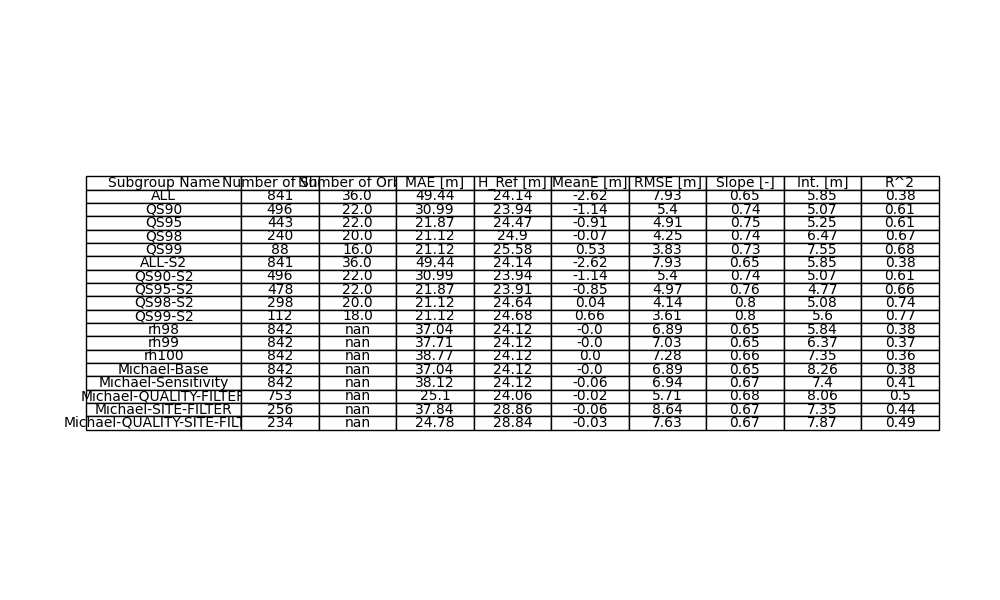



A simple algorithm with the sensitivity filter led to improvement in R^2, and sensitivity is a number we can know without knowing how well the `als_h` performed on a given LLA coordinate, giving rise to a very simple small improvement over original calibration. To further improve the calibration, I believe we would need more granular information, like original location of plane vs sattelite sample, or measurements over more locations to try to establish a greater rule about the samples. 